In [3]:
import pandas as pd
import boto3
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import psycopg2
# from sqlalchemy import create_engine
# from sqlalchemy import text

In [ ]:
# Set up a session with explicit credentials
session = boto3.Session(
    aws_access_key_id='',
    aws_secret_access_key='',
    region_name='eu-central-1' 
)

# Redshift Data API client
redshift_data = session.client('redshift-data')


In [ ]:
def run_redshift_query(sql_query, database='dev', workgroup='default-workgroup'):
    # Start the query
    response = redshift_data.execute_statement(
        WorkgroupName=workgroup,
        Database=database,
        Sql=sql_query
    )
    query_id = response['Id']

    # Wait for query to complete
    while True:
        status = redshift_data.describe_statement(Id=query_id)
        if status['Status'] == 'FINISHED':
            break
        elif status['Status'] == 'FAILED':
            raise Exception(f"Query failed: {status['Error']}")
        time.sleep(1)

   
    result = redshift_data.get_statement_result(Id=query_id)

    
    columns = [col['name'] for col in result['ColumnMetadata']]
    rows = result['Records']
    data = []
    for row in rows:
        data.append([list(cell.values())[0] if cell else None for cell in row])


    df = pd.DataFrame(data, columns=columns)
    return df


In [21]:
order_columns = run_redshift_query("SELECT table_name, column_name " \
"FROM information_schema.columns " \
"WHERE table_name IN ('orders_data', 'order_level_features', 'order_items_data') " \
"ORDER BY table_name, ordinal_position;")

order_columns 

,table_name,column_name
0,order_items_data,order_id
1,order_items_data,order_item_id
2,order_items_data,product_id
3,order_items_data,seller_id
4,order_items_data,shipping_limit_date
5,order_items_data,price
6,order_items_data,freight_value
7,order_level_features,order_id
8,order_level_features,num_items_per_order
9,order_level_features,total_price_per_order


In [ ]:
order_df = run_redshift_query(
    "SELECT of.num_items_per_order, of.total_price_per_order, of.freight_ratio, of.unique_products_per_order," \
    "of.avg_price_per_item, of.order_duration_days, of.delayed_delivery_days, od.order_purchase_timestamp," \
    "od.order_delivered_customer_date, od.order_status, od.order_id, od.customer_id," \
    "oi.price, oi.freight_value " \

    "FROM order_level_features of " \
    "JOIN orders_data od ON of.order_id = od.order_id " \
    "JOIN order_items_data oi ON of.order_id = oi.order_id "
)

order_df

,num_items_per_order,total_price_per_order,freight_ratio,unique_products_per_order,avg_price_per_item,order_duration_days,delayed_delivery_days,order_purchase_timestamp,order_delivered_customer_date,order_status,order_id,customer_id,price,freight_value
0,1,649.0,0.3,1,649.0,20,-45,2016-10-05 15:17:57,2016-10-25 20:28:33,delivered,03ffce741877a000ca0fb3520673d4c4,e937151346d1bec664f5b80cd798bdd2,649.000000,169.119995
1,1,33.0,0.5,1,33.0,7,-46,2016-10-10 07:53:34,2016-10-17 12:03:38,delivered,8213bc96304fc0881189c4525f3002f7,77069f163bef4933c6efeea244b3f606,32.990002,15.560000
2,1,99.9,0.2,1,99.9,8,-45,2016-10-10 10:20:13,2016-10-18 09:57:48,delivered,96caf486ad384c707d860dbb4e519794,b7335be40f14f35559f7222d4875b114,99.900002,16.260000
3,1,33.9,0.7,1,33.9,104,51,2017-01-12 12:01:14,2017-04-26 09:35:51,delivered,fbee80ef6891c144af8ff9dc788aaa89,41ee1607f629eea5c7aa658053748326,33.900002,24.840000
4,1,65.9,0.2,1,65.9,10,-28,2017-01-24 15:44:05,2017-02-03 17:06:20,delivered,5c5177333fb1fce1f4bb65868988f204,ebe11def265cd8e747d70c07c5a4547e,65.900002,15.670000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57399,2,196.0,0.2,1,98.0,11,-14,2018-06-08 20:45:36,2018-06-19 22:03:22,delivered,3d34e2eec4245acada65a41a949f2568,f760b1ac2bd99fbc9141d64509cacc13,98.000000,23.270000
57400,2,196.0,0.2,1,98.0,11,-14,2018-06-08 20:45:36,2018-06-19 22:03:22,delivered,3d34e2eec4245acada65a41a949f2568,f760b1ac2bd99fbc9141d64509cacc13,98.000000,23.270000
57401,1,48.0,0.3,1,48.0,9,-24,2018-06-09 19:24:53,2018-06-18 15:50:50,delivered,f44109a5bdeb8222bc76288fe1751d35,7bd8d51ba8a18440e8c429e2acc34dbf,48.000000,13.470000
57402,1,19.9,1.9,1,19.9,18,-19,2018-06-10 12:42:23,2018-06-28 15:17:02,delivered,2ce7fb3d9314c0a8e4e8c04eb1224919,695e30701cad491515e5f4f0e69bd3db,19.860001,37.040001


In [33]:
cust_df = run_redshift_query("SELECT * FROM cust_level_features")

cust_df 

,customer_id,num_orders,total_order_value,avg_order_value,avg_items_per_order,avg_delivery_time_days,avg_review_score
0,7590c5e72f02a94f0092598c1211e1e0,1,29.0,29.0,1.00000000000000000,23,2
1,bc0e1034fbb8ae2dc686562b304dd0f7,1,249.0,249.0,1.00000000000000000,6,2
2,4ac279df237d79f58d8b70addc6e5d4d,1,95.9,95.9,1.00000000000000000,10,3
3,fe874488da2abfa11a91a0ff32c5322d,1,22.0,22.0,1.00000000000000000,16,4
4,9d738b553036239b0eb45ec8d4421d70,1,230.0,230.0,1.00000000000000000,15,3
...,...,...,...,...,...,...,...
95810,a5d4658c9339e6f25f8f2e7d9b5cbc24,1,350.0,350.0,1.00000000000000000,7,4
95811,364459e1449293f93efb99239e0494d5,1,17.0,17.0,1.00000000000000000,10,4
95812,2919f0d73e4f71a70056dfeac8b81278,1,57.0,57.0,1.00000000000000000,11,3
95813,752c4baa3bc37c6bf38fc2faae997a79,1,150.0,150.0,1.00000000000000000,17,1


# Univariate Analysis

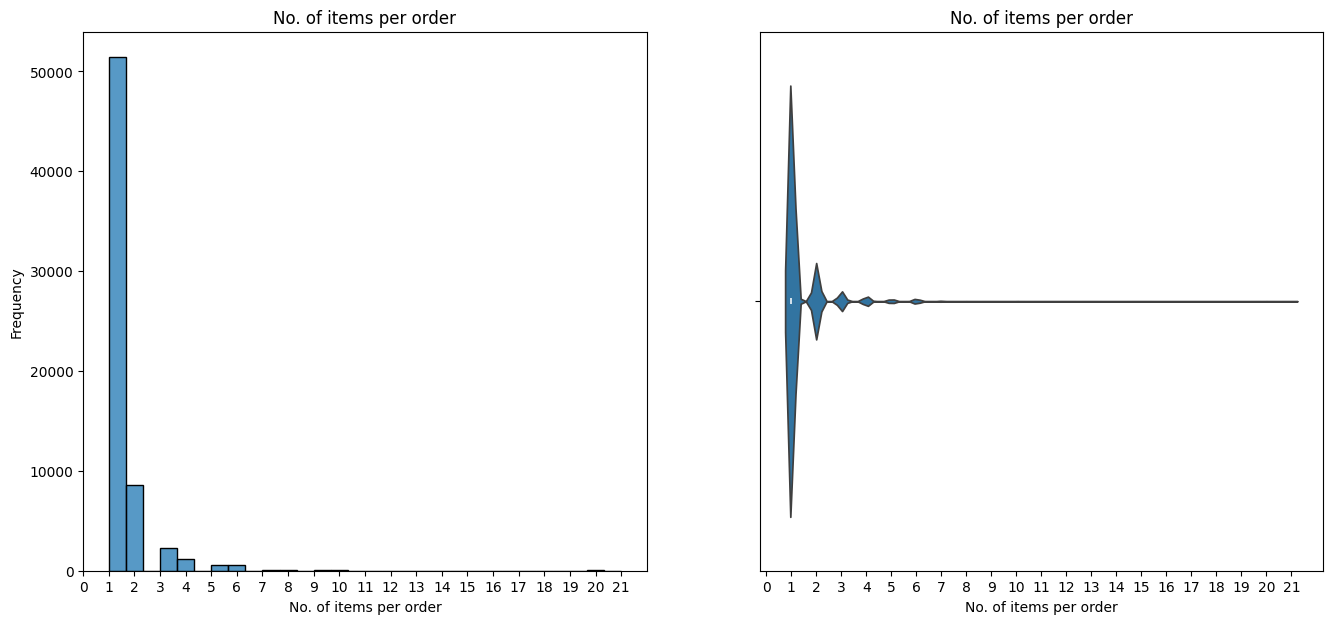

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.histplot(data=order_df, x='num_items_per_order', bins=30, ax=axes[0])
axes[0].set_title('No. of items per order')
axes[0].set_xlabel('No. of items per order')
axes[0].set_ylabel('Frequency')
max_val = order_df['num_items_per_order'].max()
axes[0].set_xticks(np.arange(0, max_val + 1, 1))

sns.violinplot(x='num_items_per_order', data=order_df, inner='box', ax=axes[1])
axes[1].set_title('No. of items per order')
axes[1].set_xlabel('No. of items per order')
max_val = order_df['num_items_per_order'].max()
axes[1].set_xticks(np.arange(0, max_val + 1, 1))

plt.show()

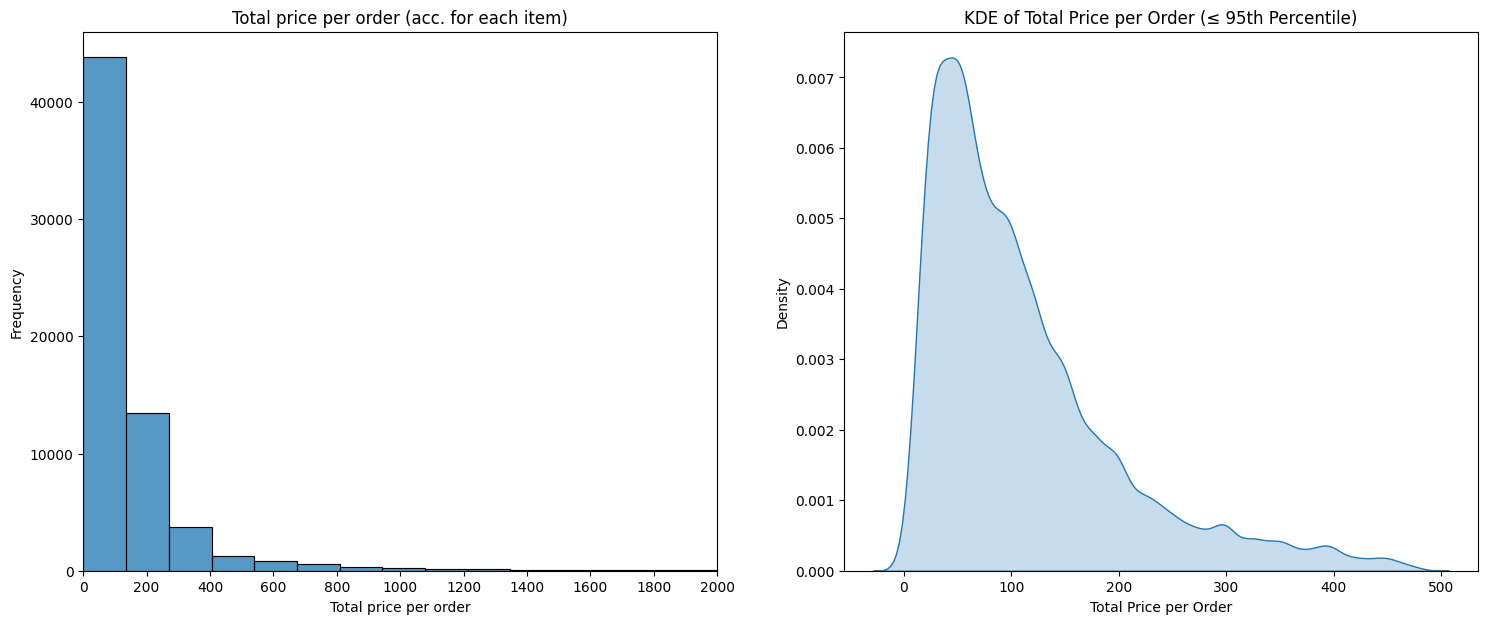

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.histplot(data=order_df, x='total_price_per_order', bins=50, ax=axes[0])
axes[0].set_title('Total price per order (acc. for each item)')
axes[0].set_xlabel('Total price per order')
axes[0].set_ylabel('Frequency')
max_val = order_df['total_price_per_order'].max()
axes[0].set_xticks(np.arange(0, max_val + 1, 200))
axes[0].set_xlim(0, 2000) 

price_cutoff = order_df['total_price_per_order'].quantile(0.95)

sns.kdeplot(order_df[order_df['total_price_per_order'] <= price_cutoff]['total_price_per_order'], fill=True, ax=axes[1])
axes[1].set_title('KDE of Total Price per Order (≤ 95th Percentile)')
axes[1].set_xlabel('Total Price per Order')
axes[1].set_ylabel('Density')

plt.show()


In [30]:
# fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# sns.histplot(data=order_df, x='price', bins=100, ax=axes[0])
# axes[0].set_title('Price per item ')
# axes[0].set_xlabel('Price per item')
# axes[0].set_ylabel('Frequency')

# sns.histplot(data=order_df, x='avg_price_per_item', bins=100, ax=axes[1])
# axes[1].set_title('Avg. price per item')
# axes[1].set_xlabel('Avg. Price per item')
# axes[1].set_ylabel('Frequency')

# plt.show()

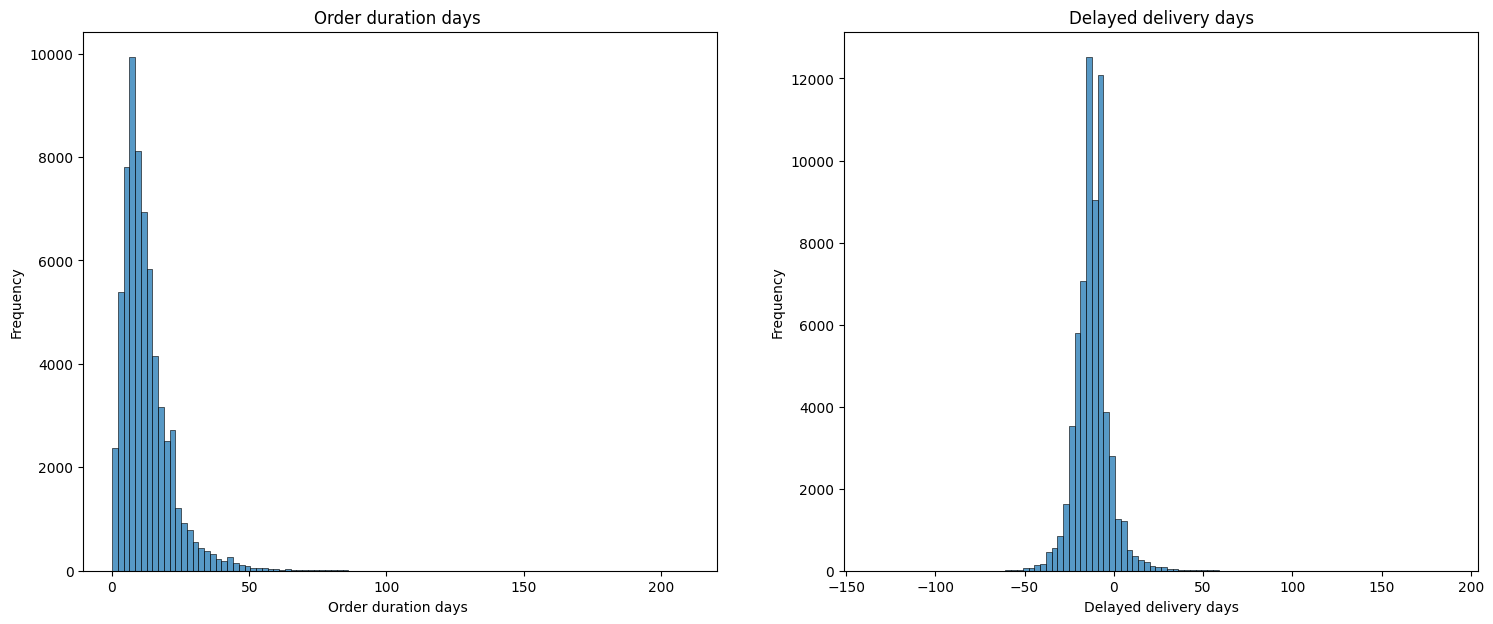

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.histplot(data=order_df, x='order_duration_days', bins=100, ax=axes[0])
axes[0].set_title('Order duration days ')
axes[0].set_xlabel('Order duration days ')
axes[0].set_ylabel('Frequency')

sns.histplot(data=order_df, x='delayed_delivery_days', bins=100, ax=axes[1])
axes[1].set_title('Delayed delivery days')
axes[1].set_xlabel('Delayed delivery days')
axes[1].set_ylabel('Frequency')

plt.show()

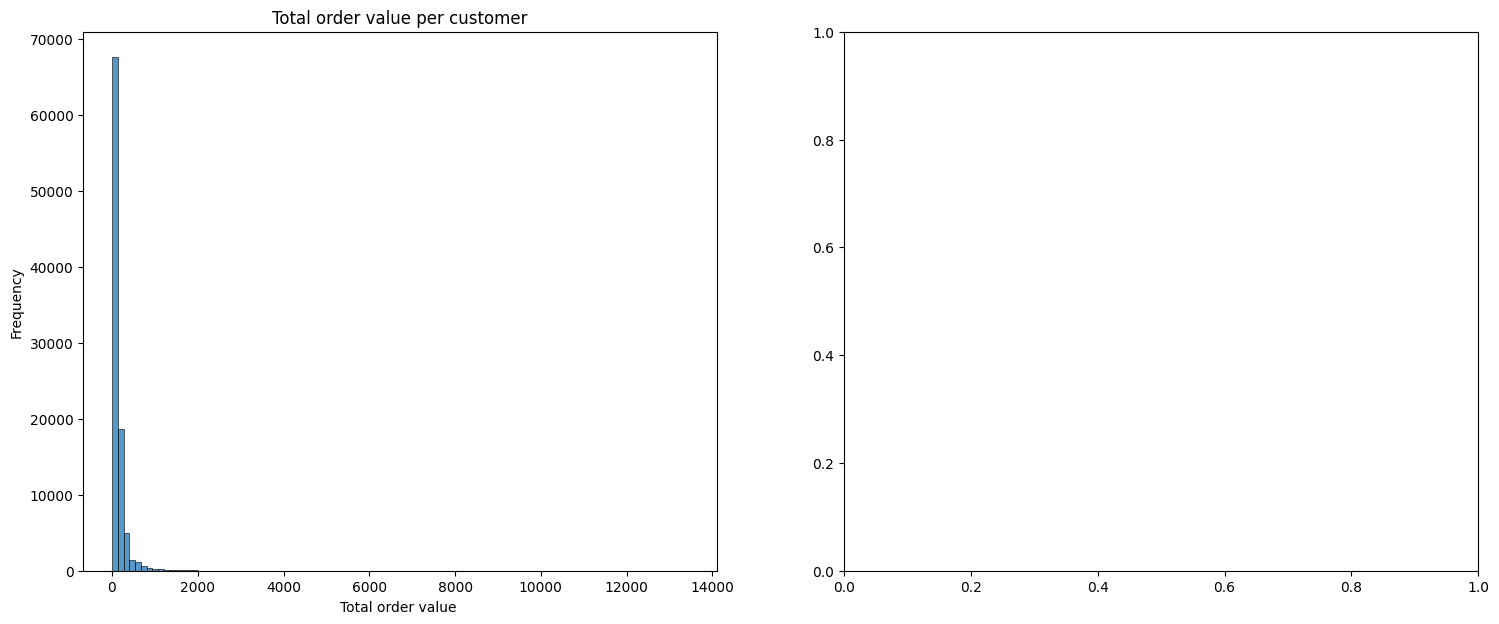

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.histplot(data=cust_df, x='total_order_value', bins=100, ax=axes[0])
axes[0].set_title('Total order value per customer')
axes[0].set_xlabel('Total order value ')
axes[0].set_ylabel('Frequency')

# sns.histplot(data=cust_df, x='total_order_valueys', bins=100, ax=axes[1])
# axes[1].set_title('Delayed delivery days')
# axes[1].set_xlabel('Delayed delivery days')
# axes[1].set_ylabel('Frequency')

plt.show()

# Bivariate Analysis

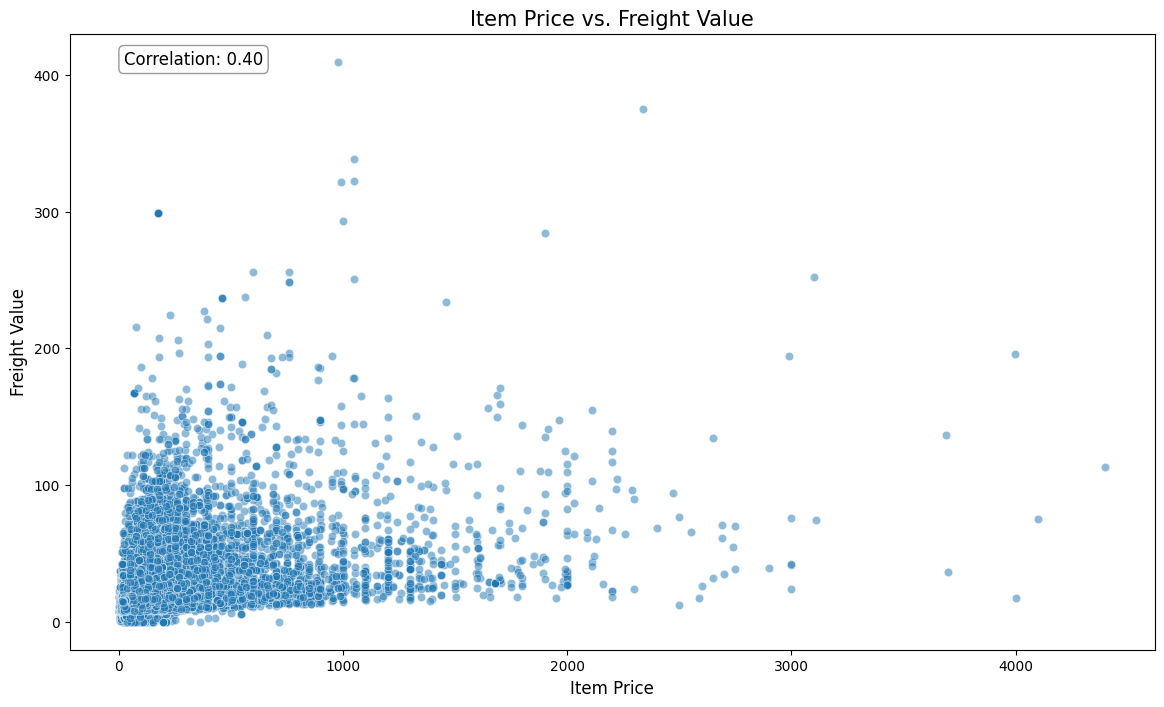

In [60]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x='price', y='freight_value', data=order_df, alpha=0.5)
plt.title('Item Price vs. Freight Value', fontsize=15)
plt.xlabel('Item Price', fontsize=12)
plt.ylabel('Freight Value', fontsize=12)

corr = order_df['price'].corr(order_df['freight_value'])
plt.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.show()

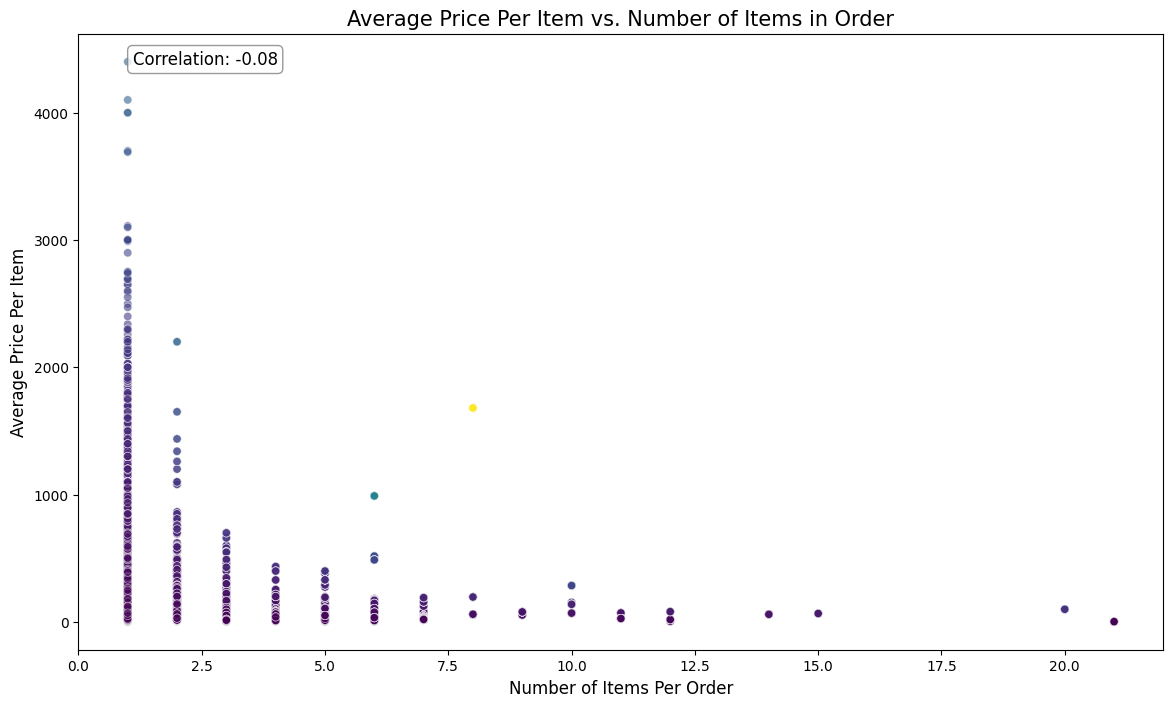

In [61]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x='num_items_per_order', y='avg_price_per_item', 
    data=order_df, alpha=0.6, hue='total_price_per_order', palette='viridis',
    legend=False)

plt.title('Average Price Per Item vs. Number of Items in Order', fontsize=15)
plt.xlabel('Number of Items Per Order', fontsize=12)
plt.ylabel('Average Price Per Item', fontsize=12)

corr = order_df['num_items_per_order'].corr(order_df['avg_price_per_item'])
plt.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# q_x = order_df['num_items_per_order'].quantile(0.99)
# q_y = order_df['avg_price_per_item'].quantile(0.99)
# plt.xlim(0, q_x)
# plt.ylim(0, q_y)

plt.show()

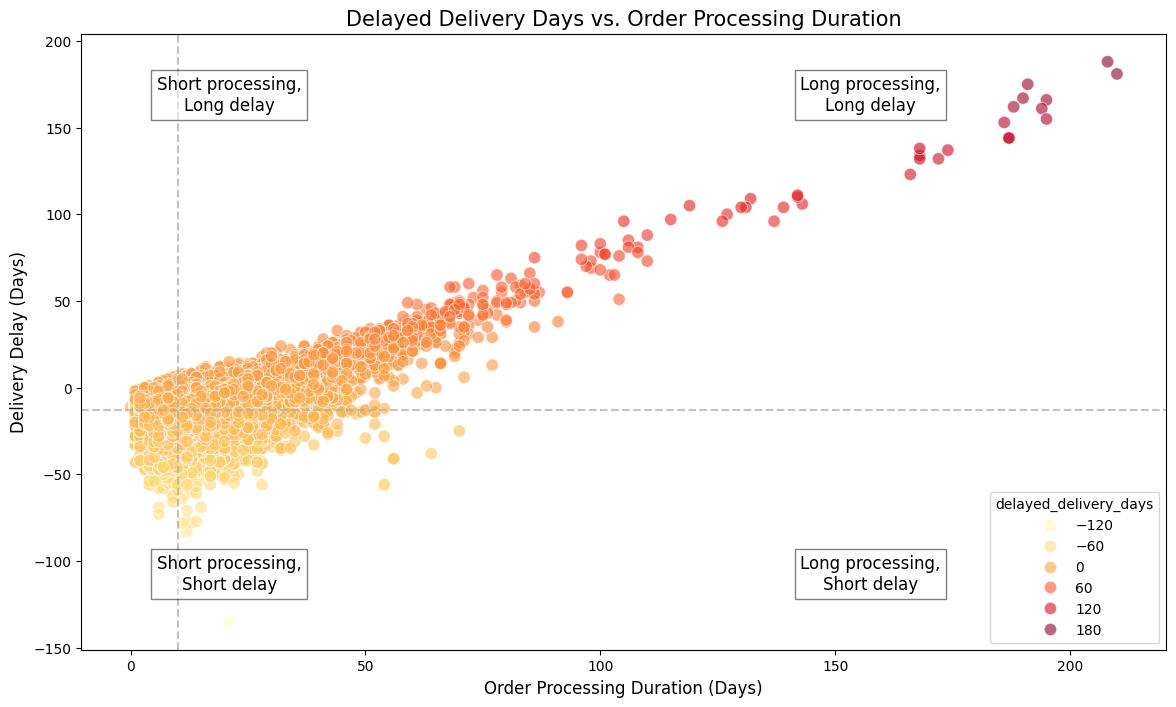

In [62]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x='order_duration_days', y='delayed_delivery_days',
    data=order_df, alpha=0.6, hue='delayed_delivery_days', palette='YlOrRd',
    edgecolor='w',s=80)

median_duration = order_df['order_duration_days'].median()
median_delay = order_df['delayed_delivery_days'].median()

plt.axvline(x=median_duration, color='darkgray', linestyle='--', alpha=0.7)
plt.axhline(y=median_delay, color='darkgray', linestyle='--', alpha=0.7)

plt.text(
    order_df['order_duration_days'].max() * 0.75, 
    order_df['delayed_delivery_days'].max() * 0.85,
    "Long processing,\nLong delay",
    fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5)
)
plt.text(
    order_df['order_duration_days'].min() + (order_df['order_duration_days'].max() * 0.1), 
    order_df['delayed_delivery_days'].max() * 0.85,
    "Short processing,\nLong delay",
    fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5)
)
plt.text(
    order_df['order_duration_days'].max() * 0.75, 
    order_df['delayed_delivery_days'].min() + (order_df['delayed_delivery_days'].max() * 0.1),
    "Long processing,\nShort delay",
    fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5)
)
plt.text(
    order_df['order_duration_days'].min() + (order_df['order_duration_days'].max() * 0.1), 
    order_df['delayed_delivery_days'].min() + (order_df['delayed_delivery_days'].max() * 0.1),
    "Short processing,\nShort delay",
    fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5)
)

plt.title('Delayed Delivery Days vs. Order Processing Duration', fontsize=15)
plt.xlabel('Order Processing Duration (Days)', fontsize=12)
plt.ylabel('Delivery Delay (Days)', fontsize=12)

plt.show()

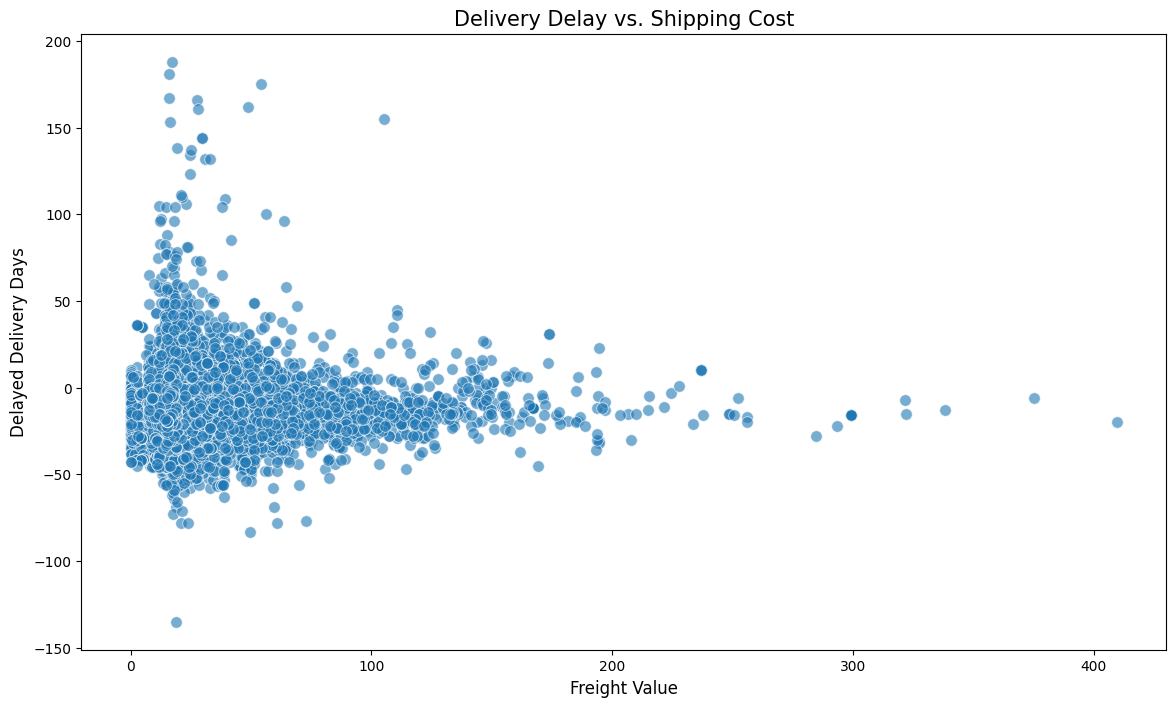

In [63]:
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(x='freight_value', y='delayed_delivery_days',
    data=order_df, alpha=0.6, edgecolor='w',s=70)

plt.title('Delivery Delay vs. Shipping Cost', fontsize=15)
plt.xlabel('Freight Value', fontsize=12)
plt.ylabel('Delayed Delivery Days', fontsize=12)

plt.show()

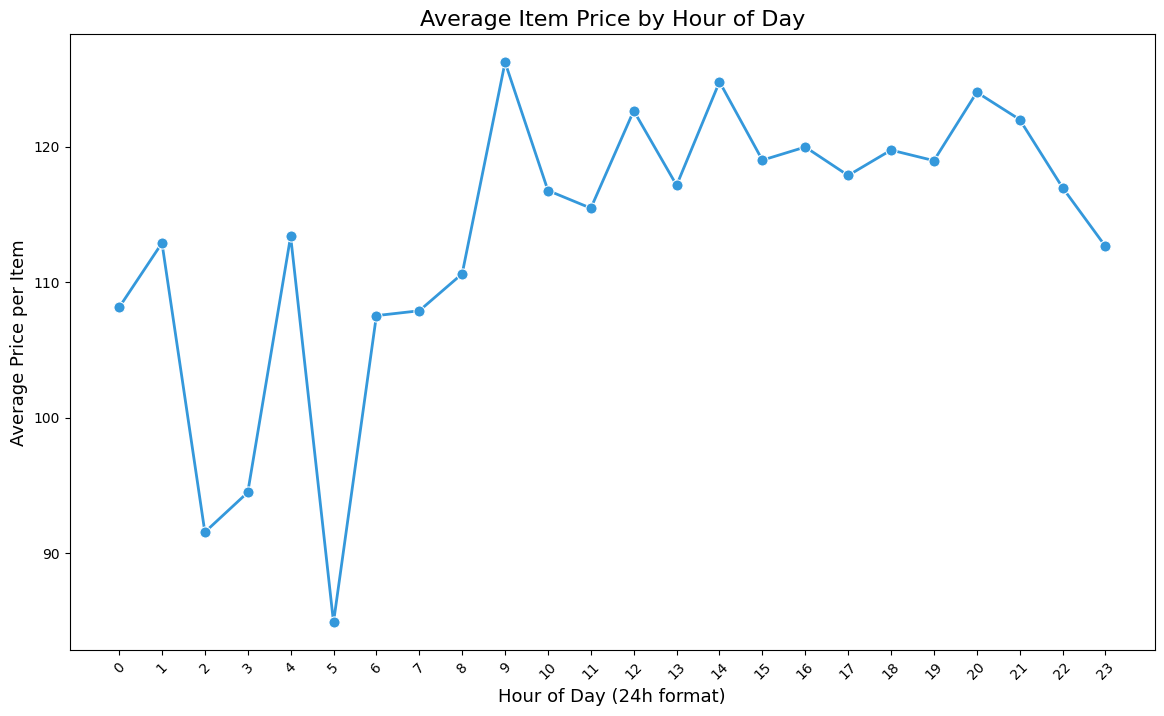

In [64]:
plt.figure(figsize=(14, 8))
order_df['order_purchase_timestamp'] = pd.to_datetime(order_df['order_purchase_timestamp'])

order_df['hour'] = order_df['order_purchase_timestamp'].dt.hour
order_df['day_of_week'] = order_df['order_purchase_timestamp'].dt.dayofweek  
order_df['day_name'] = order_df['order_purchase_timestamp'].dt.day_name()
order_df['month'] = order_df['order_purchase_timestamp'].dt.month
order_df['date'] = order_df['order_purchase_timestamp'].dt.date

hourly_avg = order_df.groupby('hour')['avg_price_per_item'].mean().reset_index()

sns.lineplot(x='hour', y='avg_price_per_item', data=hourly_avg, marker='o',
    markersize=8, color='#3498db', linewidth=2)

plt.title('Average Item Price by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (24h format)', fontsize=13)
plt.ylabel('Average Price per Item', fontsize=13)
plt.xticks(np.arange(0, 24), rotation=45)

plt.show()


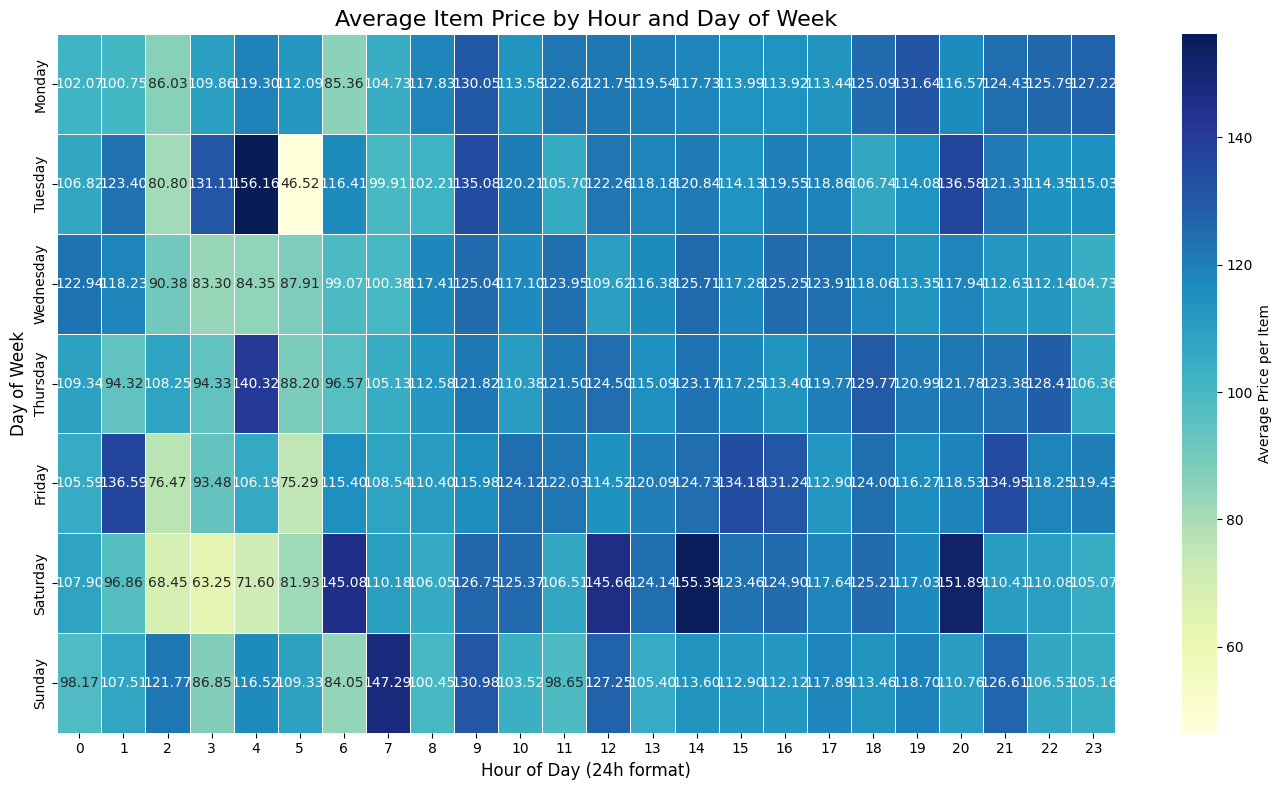

In [ ]:
plt.figure(figsize=(14, 8))


heatmap_data = order_df.groupby(['day_of_week', 'hour'])['avg_price_per_item'].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index='day_of_week', columns='hour', values='avg_price_per_item')

ax = sns.heatmap(
    heatmap_pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cbar_kws={'label': 'Average Price per Item'}
)

ax.set_ylabel('Day of Week', fontsize=12)
ax.set_xlabel('Hour of Day (24h format)', fontsize=12)
ax.set_title('Average Item Price by Hour and Day of Week', fontsize=16)

ax.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.tight_layout()
plt.show()


# Feature Engineering & Model Training
## 1. Total price per order


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [103]:
order_df['order_purchase_timestamp'] = pd.to_datetime(order_df['order_purchase_timestamp'])
order_df['purchase_hour'] = order_df['order_purchase_timestamp'].dt.hour
order_df['purchase_day_of_week'] = order_df['order_purchase_timestamp'].dt.dayofweek
order_df['purchase_month'] = order_df['order_purchase_timestamp'].dt.month
order_df['is_weekend'] = order_df['purchase_day_of_week'].isin([5, 6]).astype(int)

In [104]:
y = order_df['total_price_per_order']

features = [
    'num_items_per_order',
    'avg_price_per_item',
    'freight_ratio',
    'unique_products_per_order',
    'freight_value',
    'order_status',
    'purchase_hour',
    'purchase_day_of_week',
    'purchase_month',
    'is_weekend'
]

X = order_df[features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numerical_features = [
    'num_items_per_order',
    'avg_price_per_item',
    'freight_ratio',
    'unique_products_per_order',
    'freight_value',
    'purchase_hour',
    'purchase_day_of_week',
    'purchase_month',
    'is_weekend'
]
categorical_features = ['order_status']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

### Using XGBoost and its evaluation

In [105]:
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
) 

pipeline = Pipeline([
    ('preprocess', preprocessor),   
    ('model', xgb_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [106]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(results_df.head(10))

Mean Squared Error: 1019.96
R² Score: 0.98
       Actual   Predicted
23780    35.9   34.739750
35661   169.0  166.839035
6201    180.0  180.948975
20041    40.9   40.002892
57468   140.0  139.343582
53179    49.4   49.306038
7801    173.4  174.080246
62247    13.9   14.021147
12440    46.0   47.170525
25730   109.0  109.760788


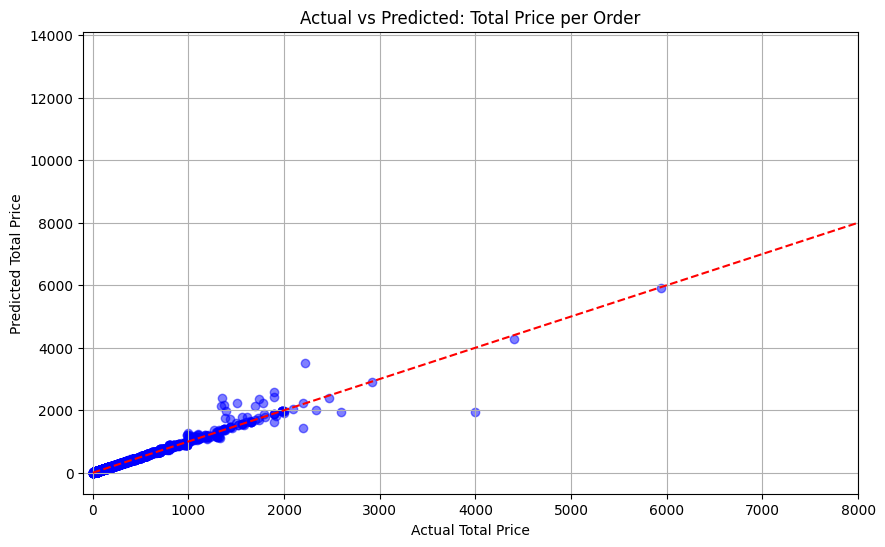

In [107]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Total Price')
plt.xlim(-100, 8000)
plt.ylabel('Predicted Total Price')
plt.title('Actual vs Predicted: Total Price per Order')

plt.grid()
plt.show()


### Using Random Forest and its evaluation

In [108]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1  
)

pipeline2 = Pipeline([
    ('preprocess', preprocessor),
    ('model', rf_model)
])

pipeline2.fit(X_train, y_train)
y_pred2 = pipeline2.predict(X_test)

In [109]:
mse = mean_squared_error(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)

print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

MSE: 37.79
R² Score: 1.00


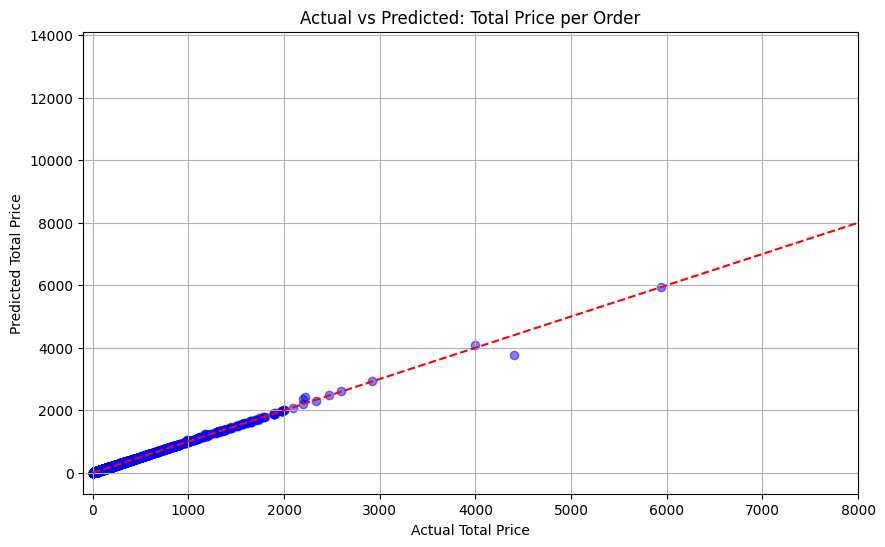

In [110]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred2, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Total Price')
plt.xlim(-100, 8000)
plt.ylabel('Predicted Total Price')
plt.title('Actual vs Predicted: Total Price per Order')

plt.grid()
plt.show()


## 2. Delayed delivery indicator

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

In [113]:
order_df['delayed_delivery_indicator'] = \
    (order_df['delayed_delivery_days'] > 0).astype(int)

y = order_df['delayed_delivery_indicator']

features = [
    'num_items_per_order',
    'avg_price_per_item',
    'freight_ratio',
    'unique_products_per_order',
    'freight_value',
    'order_status',
    'purchase_hour',
    'purchase_day_of_week',
    'purchase_month',
    'is_weekend'
]

X = order_df[features]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numerical_features = [
    'num_items_per_order', 
    'avg_price_per_item', 
    'freight_ratio',
    'unique_products_per_order', 
    'freight_value',
    'purchase_hour', 
    'purchase_day_of_week', 
    'purchase_month', 
    'is_weekend'
]
categorical_features = ['order_status']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])


In [116]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[12091    42]
 [  721   145]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     12133
           1       0.78      0.17      0.28       866

    accuracy                           0.94     12999
   macro avg       0.86      0.58      0.62     12999
weighted avg       0.93      0.94      0.92     12999



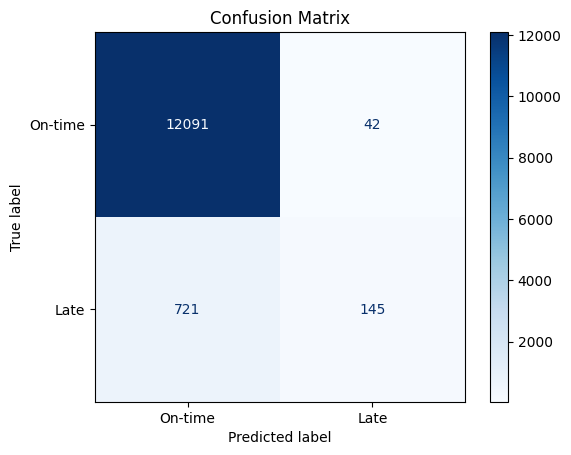

In [123]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On-time", "Late"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

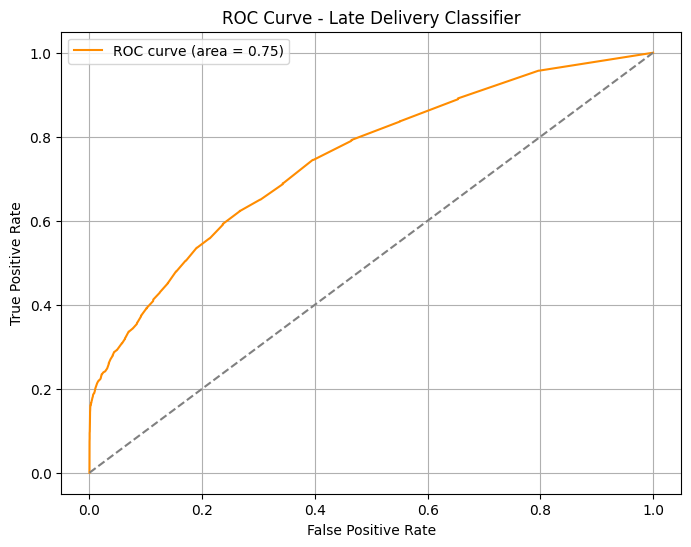

In [ ]:
y_probs = pipeline.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Late Delivery Classifier')

plt.legend()
plt.grid()
plt.show()

## 3. Customer Lifetime Value (CLV)

In [ ]:
# merging orders and customer data dataframes
total_df = pd.merge(order_df, cust_df, on='customer_id', how='left')
total_df

,num_items_per_order,total_price_per_order,freight_ratio,unique_products_per_order,avg_price_per_item,order_duration_days,delayed_delivery_days,order_purchase_timestamp,order_delivered_customer_date,order_status,order_id,customer_id,price,freight_value,num_orders,total_order_value,avg_order_value,avg_items_per_order,avg_delivery_time_days,avg_review_score
0,1,649.0,0.3,1,649.0,20,-45,2016-10-05 15:17:57,2016-10-25 20:28:33,delivered,03ffce741877a000ca0fb3520673d4c4,e937151346d1bec664f5b80cd798bdd2,649.000000,169.119995,1.0,649.0,649.0,1.00000000000000000,20.0,5.0
1,1,33.0,0.5,1,33.0,7,-46,2016-10-10 07:53:34,2016-10-17 12:03:38,delivered,8213bc96304fc0881189c4525f3002f7,77069f163bef4933c6efeea244b3f606,32.990002,15.560000,1.0,33.0,33.0,1.00000000000000000,7.0,5.0
2,1,99.9,0.2,1,99.9,8,-45,2016-10-10 10:20:13,2016-10-18 09:57:48,delivered,96caf486ad384c707d860dbb4e519794,b7335be40f14f35559f7222d4875b114,99.900002,16.260000,1.0,99.9,99.9,1.00000000000000000,8.0,5.0
3,1,33.9,0.7,1,33.9,104,51,2017-01-12 12:01:14,2017-04-26 09:35:51,delivered,fbee80ef6891c144af8ff9dc788aaa89,41ee1607f629eea5c7aa658053748326,33.900002,24.840000,1.0,33.9,33.9,1.00000000000000000,104.0,1.0
4,1,65.9,0.2,1,65.9,10,-28,2017-01-24 15:44:05,2017-02-03 17:06:20,delivered,5c5177333fb1fce1f4bb65868988f204,ebe11def265cd8e747d70c07c5a4547e,65.900002,15.670000,1.0,65.9,65.9,1.00000000000000000,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57399,2,196.0,0.2,1,98.0,11,-14,2018-06-08 20:45:36,2018-06-19 22:03:22,delivered,3d34e2eec4245acada65a41a949f2568,f760b1ac2bd99fbc9141d64509cacc13,98.000000,23.270000,2.0,196.0,98.0,2.00000000000000000,11.0,1.0
57400,2,196.0,0.2,1,98.0,11,-14,2018-06-08 20:45:36,2018-06-19 22:03:22,delivered,3d34e2eec4245acada65a41a949f2568,f760b1ac2bd99fbc9141d64509cacc13,98.000000,23.270000,2.0,196.0,98.0,2.00000000000000000,11.0,1.0
57401,1,48.0,0.3,1,48.0,9,-24,2018-06-09 19:24:53,2018-06-18 15:50:50,delivered,f44109a5bdeb8222bc76288fe1751d35,7bd8d51ba8a18440e8c429e2acc34dbf,48.000000,13.470000,1.0,48.0,48.0,1.00000000000000000,9.0,4.0
57402,1,19.9,1.9,1,19.9,18,-19,2018-06-10 12:42:23,2018-06-28 15:17:02,delivered,2ce7fb3d9314c0a8e4e8c04eb1224919,695e30701cad491515e5f4f0e69bd3db,19.860001,37.040001,1.0,19.9,19.9,1.00000000000000000,18.0,5.0


In [ ]:
total_df['order_purchase_timestamp'] = pd.to_datetime(
    total_df['order_purchase_timestamp'])

# aggregating features per customer
customer_data = total_df.groupby('customer_id').agg(
    {
        'order_id': 'nunique',
        'total_price_per_order': ['sum', 'mean'],
        'num_items_per_order': 'mean',                     
        'delayed_delivery_days': 'mean',                    
        'avg_review_score': 'mean',                             
        'order_purchase_timestamp': ['min', 'max']
    }
)

customer_data.columns = ['_'.join(col).strip() for col in customer_data.columns.values]

# renaming columns appropriately
customer_data = customer_data.rename(columns={
    'order_id_nunique': 'num_orders',
    'total_price_per_order_sum': 'total_order_value',
    'total_price_per_order_mean': 'avg_order_value',
    'num_items_per_order_mean': 'avg_items_per_order',
    'delayed_delivery_days_mean': 'avg_delivery_delay',
    'review_score_mean': 'avg_review_score',
    'order_purchase_timestamp_min': 'first_order_date',
    'order_purchase_timestamp_max': 'last_order_date'
})

customer_data['order_period_days'] = (customer_data['last_order_date'] 
    - customer_data['first_order_date']).dt.days

customer_data['orders_per_month'] = customer_data['num_orders'] \
    / (customer_data['order_period_days'] / 30 + 1e-5)  


In [52]:
customer_data

,num_orders,total_order_value,avg_order_value,avg_items_per_order,avg_delivery_delay,avg_review_score_mean,first_order_date,last_order_date,order_period_days,orders_per_month
customer_id,,,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,1,89.8,89.8,1.0,-6.0,1.0,2017-11-14 16:08:26,2017-11-14 16:08:26,0,100000.0
0002414f95344307404f0ace7a26f1d5,1,149.9,149.9,1.0,-1.0,5.0,2017-08-16 13:09:20,2017-08-16 13:09:20,0,100000.0
000379cdec625522490c315e70c7a9fb,1,93.0,93.0,1.0,-5.0,4.0,2018-04-02 13:42:17,2018-04-02 13:42:17,0,100000.0
000419c5494106c306a97b5635748086,1,34.3,34.3,1.0,26.0,1.0,2018-03-02 17:47:40,2018-03-02 17:47:40,0,100000.0
00046a560d407e99b969756e0b10f282,1,120.9,120.9,1.0,-17.0,5.0,2017-12-18 11:08:30,2017-12-18 11:08:30,0,100000.0
...,...,...,...,...,...,...,...,...,...,...
fff93c1da78dafaaa304ff032abc6205,1,596.7,198.9,3.0,-20.0,5.0,2018-06-13 01:57:22,2018-06-13 01:57:22,0,100000.0
fffa0238b217e18a8adeeda0669923a3,1,35.0,35.0,1.0,-8.0,5.0,2017-09-11 16:02:18,2017-09-11 16:02:18,0,100000.0
fffb97495f78be80e2759335275df2aa,1,45.9,45.9,1.0,-11.0,5.0,2018-01-16 14:51:35,2018-01-16 14:51:35,0,100000.0


In [54]:
# cutoff to split past & future orders
cutoff_date = pd.to_datetime('2018-01-01')
past_orders = total_df[total_df['order_purchase_timestamp'] < cutoff_date]
future_orders = total_df[total_df['order_purchase_timestamp'] >= cutoff_date]

# Aggregate total value of future orders for each customer (target variable)
future_target = future_orders.groupby('customer_id')['total_price_per_order'].sum().reset_index()
future_target.columns = ['customer_id', 'future_order_value']

# Merge with past aggregated features
model_data = customer_data.reset_index().merge(future_target, on='customer_id', how='inner')


In [60]:
features = [
    'num_orders',
    'total_order_value',
    'avg_order_value',
    'avg_items_per_order',
    'avg_delivery_delay',
    'avg_review_score_mean',
    'order_period_days',
    'orders_per_month'
]

X = model_data[features]
y = model_data['future_order_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [61]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

MSE: 30.24
R² Score: 1.00


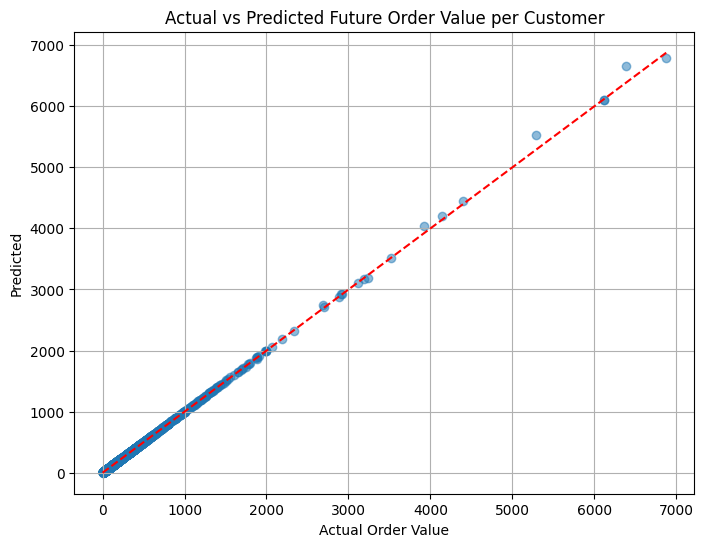

In [69]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel("Actual Order Value")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Future Order Value per Customer")

plt.grid()
plt.show()
